# **Introduction to Diffusion Models : Pytorch implementaion**
Diffusion models are a relatively recent addition to a group of algorithms known as **generative models**. It is a class of generative models that work by gradually adding noise to an image and then training a neural network to learn to remove the noise to recover the original image. This process is called diffusion, and it is inspired by the way in which physical systems tend to evolve towards a state of equilibrium.

In this introductory lab, we'll implement diffusion models from scratch using Pytorch based on the [DDPM paper](https://arxiv.org/abs/2006.11239).


**How diffusion models work ?**

  It is a process in which the structure of a given data distribution (for eg: image) is systematically and slowly destroyed through an iterative *forward diffusion process*. We then train a **Unet** to learn a *reverse diffusion process* yeilding a highly flexible and tractable generative model of data.

  In the forward diffusion process,starting from an initial point (original clean image) a random noise is iteratively sampled from a gaussian (standard normal) distribution and added to the image at each timestep until the input completely transforms into pure noise. The goal of diffusion models is to learn to reverse this process.

  In the reverse diffusion process, starting from pure gaussian noise,a small amount of noise is reduced step-by-step until we produce an output much like the original input. A neural network is trained to predict the noise added at each time step and remove it to get a less noisy image.


**How is this possible?**
Imagine that you have a glass of water and you add some ink drop into it. Initially the ink drops will be concentrated but after a while they will become evenly diluted into the glass of water. Once this process is complete, we are unable to separate the water from the ink drops since they have become homogenous.
But in the case of diffusion models, we are able to predict the noise and remove it iteratively so that we are left with the original image.
The reason that we are able to retrieve the original image in the reverse process is because we are able to store information about every timestep and compare are results with the actual change that occurred. Once our diffusion model is trained, it allows us to generate images that were not a part of our original training set.These images are part of the distribution as the original images.

# Set Up

We'll starting by importing the necessary libraries and dependencies

In [ ]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

%pip install torchmetrics
from torchmetrics import MeanMetric

from IPython.display import display, HTML, clear_output

import Unit_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# HELPER FUNCTIONS



Some utility functions for loading dataset

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and
        reshape it to have the same dimension as a batch of images.
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)

def setup_log_directory(config):
    '''Log and Model checkpoint directory Setup'''

    if os.path.isdir(config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = config.log_dir

    # Update the training config default directory
    log_dir        = os.path.join(config.root_log_dir,        version_name)
    checkpoint_dir = os.path.join(config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(log_dir,        exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")
    print(f"Model Checkpoint at: {checkpoint_dir}")

    return log_dir, checkpoint_dir



# Investigating the Dataset
We will be using the pytorch built-in [Flowers-Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) dataset which consists of around 4242 flowers images.
Let's have a look on our dataset.

# Configurations

In [ ]:
from dataclasses import dataclass

@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "Flowers" #  "MNIST", "Cifar-10", "Cifar-100",

    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"

@dataclass
class TrainingConfig:
    TIMESTEPS = 1000 # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32)
    NUM_EPOCHS = 200
    BATCH_SIZE = 128
    LR = 2e-4
    NUM_WORKERS = 2

# Load Dataset & Build Dataloader


In [ ]:

%pip install opendatasets
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadbinusman
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:11<00:00, 20.4MB/s]


Let's standardize and transform our dataset  before loading for the model.

In [ ]:
def get_dataset(dataset_name='MNIST'):
    transforms = TF.Compose(
        [
            TF.ToTensor(),
            TF.Resize((32, 32),
                      interpolation=TF.InterpolationMode.BICUBIC,
                      antialias=True),
            TF.RandomHorizontalFlip(),
            TF.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
        ]
    )

    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-10":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="/content/flowers-recognition/flowers", transform=transforms)
        # dataset = datasets.ImageFolder(root="/kaggle/input/flowers-recognition/flowers", transform=transforms)

    return dataset

def get_dataloader(dataset_name='MNIST',
                   batch_size=32,
                   pin_memory=False,
                   shuffle=True,
                   num_workers=0,
                   device="cpu"
                  ):
    dataset    = get_dataset(dataset_name=dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            pin_memory=pin_memory,
                            num_workers=num_workers,
                            shuffle=shuffle
                           )
    device_dataloader = DeviceDataLoader(dataloader, device)
    return device_dataloader

def inverse_transform(tensors):
    """Convert tensors from [-1., 1.] to [0., 255.]"""
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

# Visualize Dataset

In [ ]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device='cpu',
)

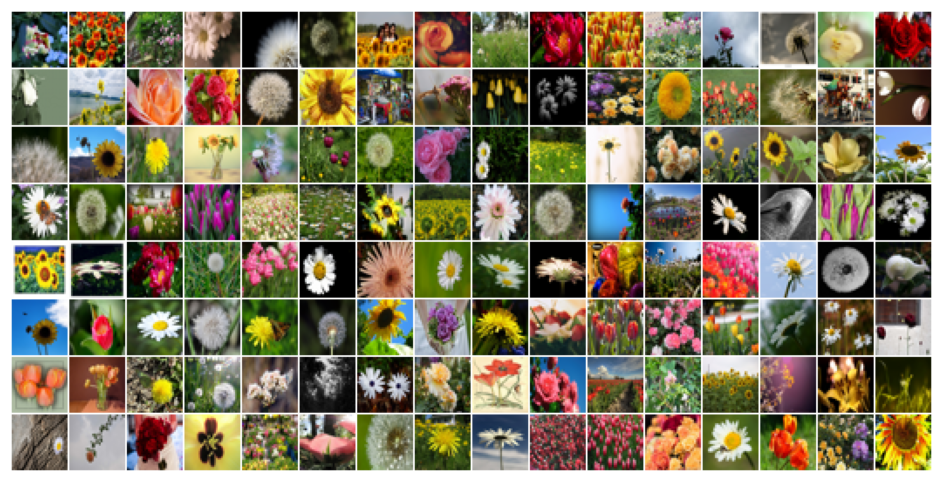

In [ ]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, nrow=16, padding=True, pad_value=1, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break

# Forward Diffusion Process

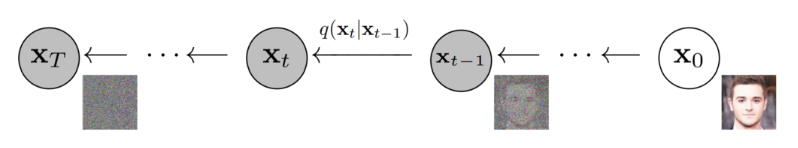

The DDPM paper describes a forward (Noising) process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>
$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I})$ <br><br>

Thus starting from `x_0`, we can obtain a fully noised image `x_T` as:

$q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>

That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t accoridng to some schedule, and determines how much noise is added per timestep.


There's a problem here, which results in an inefficient forward process 🐢.

Whenever we need a latent sample x at timestep t, we have to perform t-1 steps in the Markov chain.

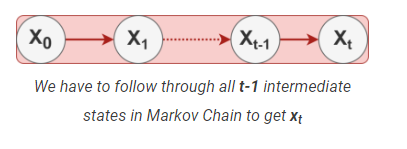

Now, we don't necessariy want to do this operation ***T*** times to get $x_{T}$ so we have another formula to get $x_t$ for any t given $x_0$, A closed form equation will be: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>
The maths notation may look scary! but this is it for the forward (noising)process.

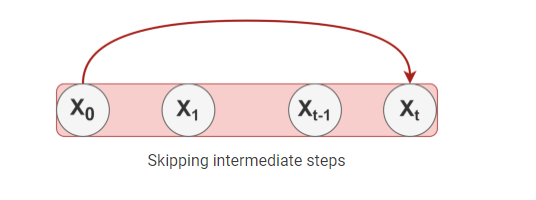



---
In the cell below, we are creating a class for a simple diffusion model.


Also, Let's precompute some values for the forward diffusion process as defined

in the `initialize` method below.

`beta` : $\beta_t$

`alpha` : $\alpha_t = 1-\beta_t$

`alpha_cumulative` : $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$

`sqrt_alpha_cumulative` : $\sqrt{\bar{\alpha}_t}$

`sqrt_one_minus_alpha_cumulative` : $\sqrt{(1-\bar{\alpha}_t)}$

 # **Lab Task #01**
 In `get_betas` method, we will schedule variance $\beta_t$. We will linearly schedule variance, while there are other options as well (eg: Cosine scheduling).

 TASK:
 - Linearly schedule `Betas` between `beta_start` and `beta_end` in `timesteps` timesteps
 - Use [`torch.linspace`](https://pytorch.org/docs/stable/generated/torch.linspace.html) utility offered by pytorch. set parameters `dtype=torch.float32`.

In [ ]:
def get_betas(timesteps=1000):
    """linear schedule, proposed in original ddpm paper"""
    scale = 1000 / timesteps
    beta_start = scale * 1e-4
    beta_end = scale * 0.02

    #### START CODE HERE ####
    Betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
    # ~! line of code
    #### END CODE HERE ####

    return Betas

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

```
torch.linspace(START,END,DIVISION STEPS)
```



</details>

Let's verify `get_betas()` method.

In [ ]:
#UNIT TESTS

Unit_test.compute_get_betas_test(get_betas)

 All tests passed.


In [ ]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()


    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = get_betas(self.num_diffusion_timesteps)
        self.alpha = 1 - self.beta

        #Needed for forward process
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)

        #Used later when sampling
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)



 # **Lab Task #02**
 Now finally, starting from an initial state `x_0` , we can obtain final noised image `x_T` after `t` timesteps
 by:

 $x_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1-\bar{\alpha}_t)}\epsilon$

 where $\epsilon$ is a random noise sampled from gaussian (standard normal) distribution.

 TASK:
 - *Implement closed form equation as above*

In [ ]:
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    eps = torch.randn_like(x0)  # Noise
    sqrt_alpha_cumulative = get(sd.sqrt_alpha_cumulative, t=timesteps)
    sqrt_one_minus_alpha_cumulative = get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps)

    #### START CODE HERE ####

    x_t = (sqrt_alpha_cumulative * x0) + (sqrt_one_minus_alpha_cumulative * eps)
    # ~ 1 line

    #### END CODE HERE ####
    return x_t, eps  # return ... , gt noise --> model predicts this)

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

  * `x_t` is just a linear combination of `sqrt_alpha_cumulative` , `sqrt_one_minus_alpha_cumulative` and `eps` respectively.

</details>

# Sample Forward Diffusion Process

You can check if your implementation was correct by running the following test code:

In [ ]:
sd = SimpleDiffusion(num_diffusion_timesteps=TrainingConfig.TIMESTEPS, device="cpu")

loader = iter(  # converting dataloader into an iterator for now.
    get_dataloader(
        dataset_name=BaseConfig.DATASET,
        batch_size=6,
        device="cpu",
    )
)

x0s, _ = next(loader)

# UNIT TESTS
Unit_test.compute_forward_process_test(forward_diffusion)

 All tests passed.


Let's verify and visualize the forward (noising) process on an example by `forward_diffusion`. To visualize the images we also need to revert the transforms we applied while loading the dataset. hence using the `inverse_transforms` function from above as well

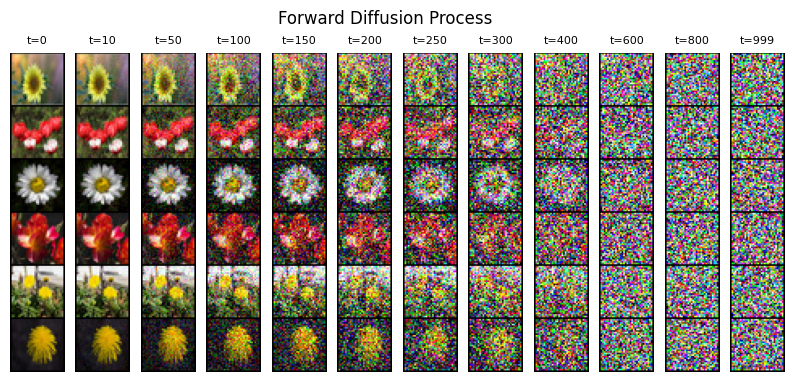

In [ ]:
noisy_images = []
specific_timesteps = [0, 10, 50, 100, 150, 200, 250, 300, 400, 600, 800, 999]

for timestep in specific_timesteps:

    timestep = torch.as_tensor(timestep, dtype=torch.long)

    xts, _ = forward_diffusion(sd, x0s, timestep)
    xts    = inverse_transform(xts) / 255.0
    xts    = make_grid(xts, nrow=1, padding=1)

    noisy_images.append(xts)

# Plot and see samples at different timesteps

_, ax = plt.subplots(1, len(noisy_images), figsize=(10, 5), facecolor='white')

for i, (timestep, noisy_sample) in enumerate(zip(specific_timesteps, noisy_images)):
    ax[i].imshow(noisy_sample.squeeze(0).permute(1, 2, 0))
    ax[i].set_title(f"t={timestep}", fontsize=8)
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward Diffusion Process", y=0.9)
plt.axis("off")
plt.show()

# UNET MODEL
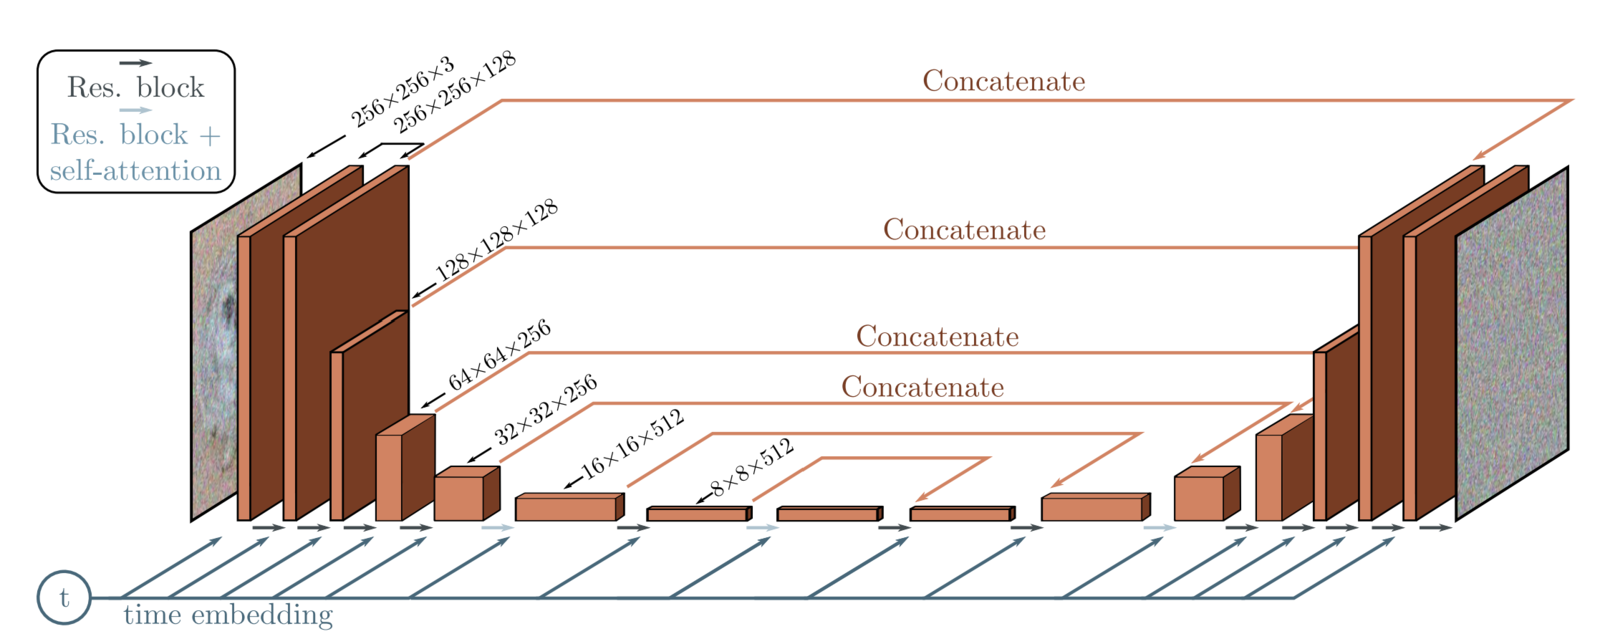

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, total_time_steps=1000, time_emb_dims=128, time_emb_dims_exp=512):
        super().__init__()

        half_dim = time_emb_dims // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)

        ts = torch.arange(total_time_steps, dtype=torch.float32)

        emb = torch.unsqueeze(ts, dim=-1) * torch.unsqueeze(emb, dim=0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        self.time_blocks = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(in_features=time_emb_dims, out_features=time_emb_dims_exp),
            nn.SiLU(),
            nn.Linear(in_features=time_emb_dims_exp, out_features=time_emb_dims_exp),
        )

    def forward(self, time):
        return self.time_blocks(time)


class AttentionBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.channels = channels

        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mhsa = nn.MultiheadAttention(embed_dim=self.channels, num_heads=4, batch_first=True)

    def forward(self, x):
        B, _, H, W = x.shape
        h = self.group_norm(x)
        h = h.reshape(B, self.channels, H * W).swapaxes(1, 2)  # [B, C, H, W] --> [B, C, H * W] --> [B, H*W, C]
        h, _ = self.mhsa(h, h, h)  # [B, H*W, C]
        h = h.swapaxes(2, 1).view(B, self.channels, H, W)  # [B, C, H*W] --> [B, C, H, W]
        return x + h


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels, dropout_rate=0.1, time_emb_dims=512, apply_attention=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.act_fn = nn.SiLU()
        # Group 1
        self.normlize_1 = nn.GroupNorm(num_groups=8, num_channels=self.in_channels)
        self.conv_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        # Group 2 time embedding
        self.dense_1 = nn.Linear(in_features=time_emb_dims, out_features=self.out_channels)

        # Group 3
        self.normlize_2 = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.conv_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding="same")

        if self.in_channels != self.out_channels:
            self.match_input = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=1)
        else:
            self.match_input = nn.Identity()

        if apply_attention:
            self.attention = AttentionBlock(channels=self.out_channels)
        else:
            self.attention = nn.Identity()

    def forward(self, x, t):
        # group 1
        h = self.act_fn(self.normlize_1(x))
        h = self.conv_1(h)

        # group 2
        # add in timestep embedding
        h += self.dense_1(self.act_fn(t))[:, :, None, None]

        # group 3
        h = self.act_fn(self.normlize_2(h))
        h = self.dropout(h)
        h = self.conv_2(h)

        # Residual and attention
        h = h + self.match_input(x)
        h = self.attention(h)

        return h


class DownSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.downsample = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x, *args):
        return self.downsample(x)


class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x, *args):
        return self.upsample(x)


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=3,
        num_res_blocks=2,
        base_channels=128,
        base_channels_multiples=(1, 2, 4, 8),
        apply_attention=(False, False, True, False),
        dropout_rate=0.1,
        time_multiple=4,
    ):
        super().__init__()

        time_emb_dims_exp = base_channels * time_multiple
        self.time_embeddings = SinusoidalPositionEmbeddings(time_emb_dims=base_channels, time_emb_dims_exp=time_emb_dims_exp)

        self.first = nn.Conv2d(in_channels=input_channels, out_channels=base_channels, kernel_size=3, stride=1, padding="same")

        num_resolutions = len(base_channels_multiples)

        # Encoder part of the UNet. Dimension reduction.
        self.encoder_blocks = nn.ModuleList()
        curr_channels = [base_channels]
        in_channels = base_channels

        for level in range(num_resolutions):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks):

                block = ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )
                self.encoder_blocks.append(block)

                in_channels = out_channels
                curr_channels.append(in_channels)

            if level != (num_resolutions - 1):
                self.encoder_blocks.append(DownSample(channels=in_channels))
                curr_channels.append(in_channels)

        # Bottleneck in between
        self.bottleneck_blocks = nn.ModuleList(
            (
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=True,
                ),
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=False,
                ),
            )
        )

        # Decoder part of the UNet. Dimension restoration with skip-connections.
        self.decoder_blocks = nn.ModuleList()

        for level in reversed(range(num_resolutions)):
            out_channels = base_channels * base_channels_multiples[level]

            for _ in range(num_res_blocks + 1):
                encoder_in_channels = curr_channels.pop()
                block = ResnetBlock(
                    in_channels=encoder_in_channels + in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    time_emb_dims=time_emb_dims_exp,
                    apply_attention=apply_attention[level],
                )

                in_channels = out_channels
                self.decoder_blocks.append(block)

            if level != 0:
                self.decoder_blocks.append(UpSample(in_channels))

        self.final = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=output_channels, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x, t):

        time_emb = self.time_embeddings(t)

        h = self.first(x)
        outs = [h]

        for layer in self.encoder_blocks:
            h = layer(h, time_emb)
            outs.append(h)

        for layer in self.bottleneck_blocks:
            h = layer(h, time_emb)

        for layer in self.decoder_blocks:
            if isinstance(layer, ResnetBlock):
                out = outs.pop()
                h = torch.cat([h, out], dim=1)
            h = layer(h, time_emb)

        h = self.final(h)

        return h

# Training

The first algorithm of DDPM paper includes training instructions for a single epoch

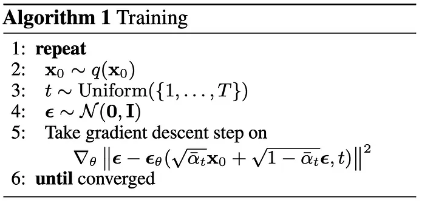



*   Sample random sample $x_0$  from gaussian distribution  $q(x_0)$   
*   Sample  $t$  uniformly between  $1.....T$  random time step.
*   Sample some random noise and corrupt the input by random noise at timestamp $t$

The neural network learns to predict this noise based on the noised image  $x_T$  (i.e noise applied on  $x_0$  based on known schedule of variance)







In [ ]:
# Algorithm 1: Training

def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800,
                   base_config=BaseConfig(), training_config=TrainingConfig()):

    loss_record = MeanMetric()
    model.train()

    # Display self-adjusting progress bars for each training loop
    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config.NUM_EPOCHS}")

        # Get all real images in the current batch inside loader
        for x0s, _ in loader: # Line 1 and 2 of Algorithm 1
            tq.update(1)

            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE) #Line 3 of Algorithm 1
            xts, gt_noise = forward_diffusion(sd, x0s, ts) #Line 4 of Algorithm 1

            with amp.autocast():
            # amp.autocast() is a context manager automatically casts operations to the appropriate
            # data type for improved performance, while maintaining numerical stability during the training process.
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise) # Line 5 of Algorithm 1

            optimizer.zero_grad(set_to_none=True) # Clear gradients of all tensors
            scaler.scale(loss).backward() # Back Propagation - Also scales the loss value to prevent underflow in the gradients during the backward pass.

            # Update model parameters
            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item() # Get numerical value of loss
            loss_record.update(loss_value) # Keep track of loss values

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}") #For output purpose

        mean_loss = loss_record.compute().item()

        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")

    return mean_loss

# Sampling

The second DDPM algorithm explains sampling from the model during training (in order to track progress)

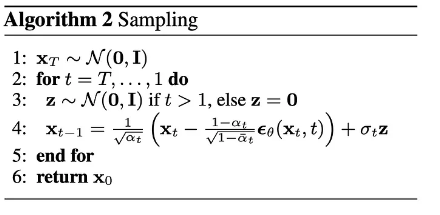

Continuing from reverse diffusion process at the last timestep $T$,

 1. Sample random sample $x_T$ from gaussian distribution
 2. The neural network denoises it until timestep t=T......0 to compute $x_{t-1}$.

Ideally,we end up with an image that looks like it came from the original data distribution.

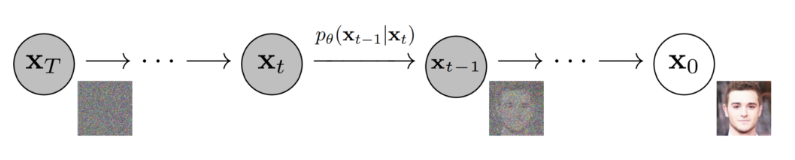

# **Lab Task #03**
During Sampling or reverse diffusion, For each timestep we predict noise `predicted_noise` to subtract from the noisy versions starting from $x_T$ all the way to $..x_t,x_{t-1},..,x_0$ until we get a sample from original distribution.

Thus, after removing scaled noise from samples of previous(deeper in latent space) timestep $t$ , we can obtain a slightly denoised sample at timestep $t-1$ (earlier in latent space) by:

$x_{t-1} = \frac{1}{\sqrt{{\alpha}_t}} (x_t - \frac{1-{\alpha}_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_{\theta}(x_t,t)) + \sigma_t z$

TASK:
-  *implement the above equation to obtain denoisy sample*

In [ ]:
# Algorithm 2: Sampling

@torch.inference_mode()
def reverse_diffusion(model, sd, timesteps=1000, img_shape=(3, 64, 64),
                      num_images=5, nrow=8, device="cpu", **kwargs):

    x_t = torch.randn((num_images, *img_shape), device=device) # Line1 of Algorithm 2
    model.eval()

    #Line2 of Algorithm 2
    for time_step in tqdm(iterable=reversed(range(1, timesteps)),
                          total=timesteps-1, dynamic_ncols=False,
                          desc="Sampling :: ", position=0):

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step # To send in the model
        z = torch.randn_like(x_t) if time_step > 1 else torch.zeros_like(x_t) # Line3 of Algorithm 2

        predicted_noise = model(x_t, ts) #Send into the model the noisy sample at a given timestep and get the predicted noise

        #These were initialized in SimpleDiffusion class above
        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts)

        # computing x_t-1 , #Line4 of Algorithm 2


        #### START CODE HERE ####
        x_t_minus_one = (one_by_sqrt_alpha_t * (x_t - (beta_t / sqrt_one_minus_alpha_cumulative_t ) * predicted_noise )) + torch.sqrt(beta_t) * z
        # ~ 1 line

        #### END CODE HERE ####


   # Display and save the image at the final timestep of the reverse process.
    x_t_minus_one = inverse_transform(x_t_minus_one).type(torch.uint8)
    grid = torchvision.utils.make_grid(x_t_minus_one, nrow=nrow, pad_value=255.0).to("cpu")
    pil_image = TF.functional.to_pil_image(grid)
    pil_image.save(kwargs['save_path'], format=save_path[-3:].upper())
    display(pil_image)
    return None

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

  *  $β_t = 1- α_t$
  * `x_t_minus_one` is just a linear combination of `one_by_sqrt_alpha_t` , `beta_t`, `sqrt_one_minus_alpha_cumulative_t` and `predicted_noise` respectively.

  <details>
  <summary><font size="2" color="Blue"><b>More hint</b></font></summary>

  Implementation
    ```
     x_t_minus_one = (
             one_by_sqrt_alpha_t
             * (x_t - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
             + torch.sqrt(beta_t) * z
             )
    ```


  </details>

</details>



# Setting Neural Network configurations

In [ ]:
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 512
    BASE_CH_MULT = (1, 2, 4, 8) # 32, 16, 8, 4
    APPLY_ATTENTION = (False, False, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 2 # 128

Let's instantiate the model with `ModelConfig`. We use the Adam's optimizer and *MSE* loss.


In [ ]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

scaler = amp.GradScaler()


# Why Mean Squared Loss?

Ideally, we would like to calculate the negative log likelihood of the probability that we obtain the original image after denoising it

  $-log⁡(p_θ (x_0 ))$

but this requires us to keep track of all timesteps from ${x_T}$ to ${x_1}$ that come before ${x_0}$. This is not possible so as a solution we use the variational lower bound,


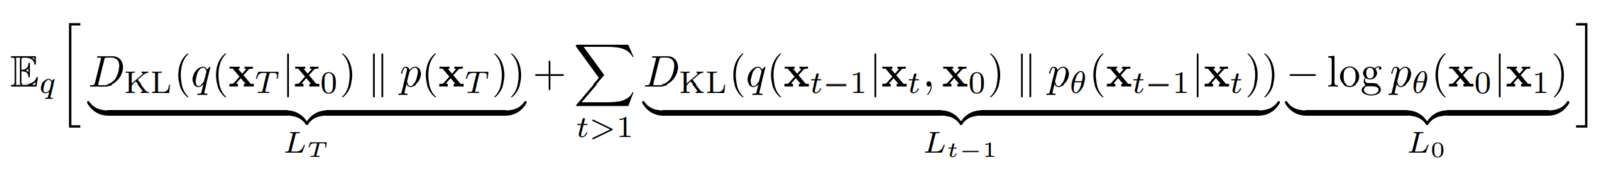

Simplifying this further we get an equation that seems oddly familiar.

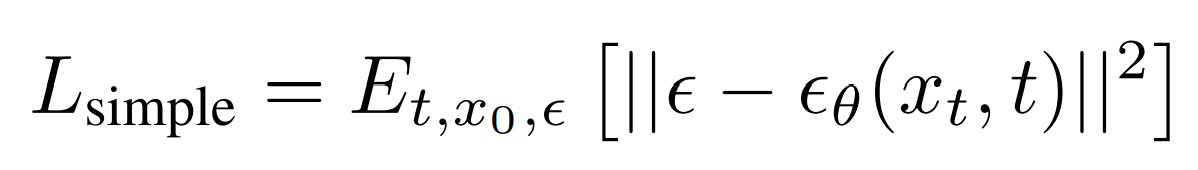

Hence we use the **MSELoss** where we minimize the difference between the actual noise added and the predicted noise.

# **Lab Task #04**

TASK:
-  *Lets initialize the MSE loss*

In [ ]:
#### START CODE HERE ####
loss_fn = nn.MSELoss()
# ~ 1 line

#### END CODE HERE ####

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>


```
loss_fn=nn.MSELoss()
```



</details>

Also creating Checkpoints directory for saving model, optimizer and scaler states during training.

In [ ]:
total_epochs = TrainingConfig.NUM_EPOCHS + 1
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())

ext = ".png"

Logging at: Logs_Checkpoints/Inference/version_0
Model Checkpoint at: Logs_Checkpoints/checkpoints/version_0


Training in batches for `total_epochs`

In [ ]:
for epoch in range(1, total_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)

    if epoch % 5 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")

        # Algorithm 2: Sampling
        reverse_diffusion(model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=32,
            save_path=save_path, img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
        )

        # clear_output()
        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        # checkpoint_dir = '/content/drive/MyDrive/'
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar")) #Saving checkpoints every 5th epoch
        del checkpoint_dict

# Inference
Let's load the saved checkpoint and observe some outputs

In [ ]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)

# checkpoint_dir = "/kaggle/working/Logs_Checkpoints/checkpoints/version_0"
# checkpoint_dir = "/content/Logs_Checkpoints/checkpoints/version_0"
checkpoint_dir = "/content/drive/MyDrive/"

model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ckpt.tar"), map_location='cpu')['model'])

model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

In [ ]:
ext = ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=16,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=8,
)
print(save_path)

In [ ]:
ext = ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=64,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=32,
)
print(save_path)

In [ ]:
ext = ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

reverse_diffusion(
    model,
    sd,
    num_images=256,
    save_path=save_path,
    timesteps=1000,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
    nrow=8,
)
print(save_path)